In [77]:
import csv
import pandas as pd
import numpy as np
import math
from collections import Counter
from tqdm import tqdm
import networkx as nx
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from keras.utils import to_categorical
from keras import regularizers
from sklearn.metrics import roc_auc_score
from keras import optimizers
from matplotlib import pyplot as plt
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, log_loss
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
Retweet_data=pd.read_csv("Retweet-Data (with No of Followers and likes).csv")

In [5]:
Retweet_data.head()

,FollowerId,FolloweeId,Follower-Name,No-Of-Followers,No-Of-Friends,Statuses-Count,Tweet-Id,Tweet,Retweet-Count,Tweet-Time,Retweet-Time,Likes,Language,Followe-Friend
0,939762653076979712,1019469630,_sabanaqvi,377583,972,7749,1232283733283295232,I am not one of those who insists @ArvindKejri...,742,Tue Feb 25 12:38:31 +0000 2020,Wed Feb 26 13:26:03 +0000 2020,2338,en,321
1,1217295566255738880,2441854915,Sanju_Verma_,92724,235,47801,1232652113399824386,3.14 crore minority students secured govt scho...,64,Wed Feb 26 13:02:20 +0000 2020,Wed Feb 26 13:26:03 +0000 2020,108,en,304
2,1208393191554265090,941866180129669120,yatisharma111,36278,23418,2949,1232645430619627523,हिंसा के दौरान मारे गए लोगों को मुआवजे का प्रा...,15,Wed Feb 26 12:35:46 +0000 2020,Wed Feb 26 13:26:01 +0000 2020,85,hi,166
3,1218592033620877323,44425241,AdityaRajKaul,252031,9430,70784,1232578382908608513,Family members of young Ankit Sharma the Secur...,591,Wed Feb 26 08:09:21 +0000 2020,Wed Feb 26 13:26:00 +0000 2020,1131,en,101
4,894773304329777153,48672667,RajeIyer,8492,439,93577,1232572303189299200,Again he showed Middle finger to Media fake ne...,60,Wed Feb 26 07:45:11 +0000 2020,Wed Feb 26 13:26:00 +0000 2020,112,en,5002


#### Make Follower-Followee Directed Graph

In [6]:
Twitter_Graph=nx.DiGraph()

In [7]:
for i in tqdm(range(len(Retweet_data))):
    Twitter_Graph.add_edge(Retweet_data.iloc[i]['FollowerId'],Retweet_data.iloc[i]['FolloweeId'])

100%|████████████████████████████████████████████████████████████████████████| 135147/135147 [01:04<00:00, 2110.88it/s]


In [8]:
Degree_central=nx.degree_centrality(Twitter_Graph)

#### Make Data for the Followee 

In [9]:
# Make followee ids list
Followee_Id=list(Retweet_data['FolloweeId'].unique())

In [10]:
new_columns=[ 'No-Of-Followers','No-Of-Friends', 'Statuses-Count', 'Retweet-Count','Likes' ,'Followe-Friend']

In [11]:
Data=pd.DataFrame(index=Followee_Id,columns=new_columns)

In [12]:
for i in tqdm(range(len(Retweet_data))):
    Data.loc[Retweet_data.iloc[i]['FolloweeId']]=Retweet_data.iloc[i][new_columns]

100%|█████████████████████████████████████████████████████████████████████████| 135147/135147 [03:24<00:00, 661.14it/s]


### Make Final Features DataFrame

In [13]:
Results=pd.DataFrame(index=Followee_Id)
N=len(Retweet_data)

#### User Activity Measure 

In [14]:
### General Activity Measure
Results['General_Activity_Measure']=Data['Statuses-Count']+Data['Retweet-Count']+Data['Likes']  

In [15]:
### Topical signal
Results['Topical signal']=(Data['Statuses-Count']+Data['Retweet-Count'])/N

In [16]:
### signal Strength
Results['Signal Strength']=Data['Statuses-Count']/(Data['Statuses-Count']+Data['Retweet-Count'])

#### Popularity Measure

In [17]:
#### Follower Rank
Results['Follower Rank']=Data['No-Of-Followers']/(Data['No-Of-Followers']+Data['No-Of-Friends'])

In [18]:
#### Popularity 
Results['Popularity']=1-(Data['No-Of-Followers']**2.718)

In [22]:
#### Degree Centralirty
degree_central_score=[]
for node in Followee_Id:
    degree_central_score.append(Degree_central[node])
    
for node in tqdm(Followee_Id):
    Results['degree_centrality']=degree_central_score

100%|████████████████████████████████████████████████████████████████████████████| 3356/3356 [00:01<00:00, 1839.75it/s]


In [23]:
Results['Label']=0

In [24]:
Results.shape

(3356, 7)

#### Feature Threshold 

In [25]:
Results.loc[(Results['Follower Rank'] > 0.05 ) & (Results['Topical signal'] > 0.05) 
            &(Results['Signal Strength'] > 0.50 ) & (Results['Popularity'] < -1.000000000e+6)
            & (Results['General_Activity_Measure'] > 7000 ) ,'Label']=1

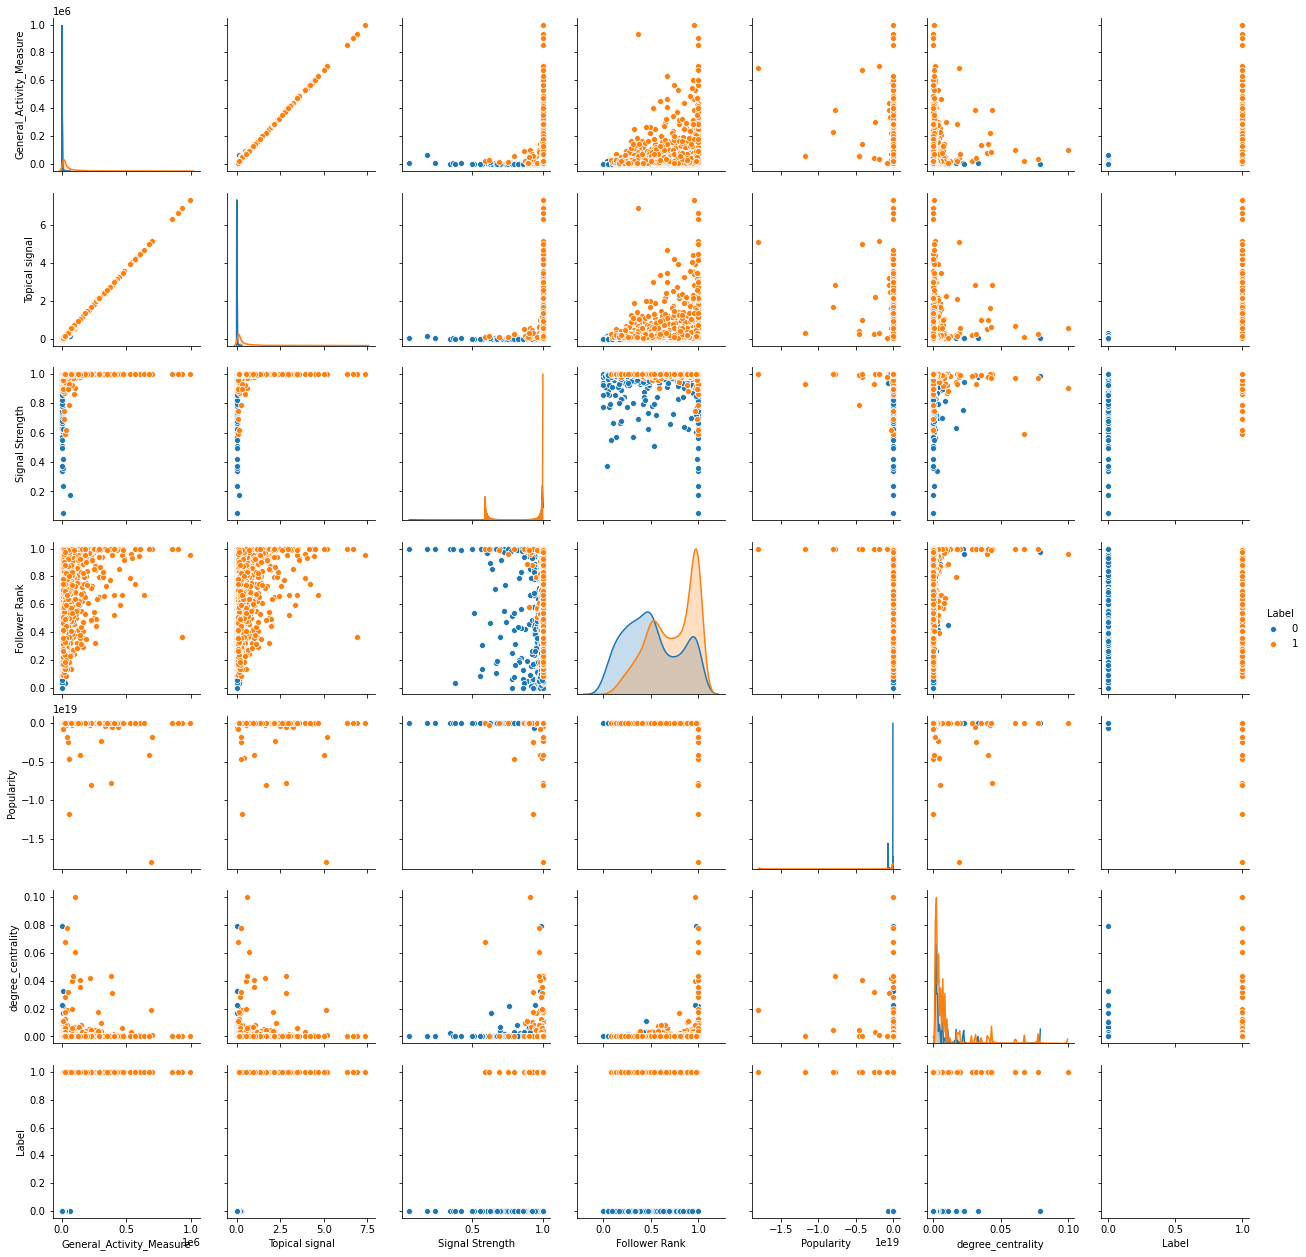

In [26]:
sns.pairplot(Results, hue='Label')

### Making Training and Testing data

In [45]:
Y=pd.DataFrame()
Y['Label']=Results['Label']

In [46]:
df_train, df_test,label_train,label_test= train_test_split(Results,Y,stratify=Y,test_size=0.3,shuffle=True,)

In [47]:
df_train=df_train.drop(labels='Label',axis=1)
df_test=df_test.drop(labels='Label',axis=1)

In [48]:
df_train['Follower Rank'].fillna(0.0,inplace=True)
df_test['Follower Rank'].fillna(0.0,inplace=True)

In [49]:
df_test.shape

(1007, 6)

### Data Normalization and preprocessing

In [50]:
mm_scaler = preprocessing.MinMaxScaler()
df_train_normalize = mm_scaler.fit_transform(df_train)
df_test_normalize=mm_scaler.transform(df_test)

### Apply Multi layer perceptron Model

In [51]:
Y_train = to_categorical(label_train)
Y_test = to_categorical(label_test)

In [52]:
model1 = Sequential()
model1.add(Dense(8, input_dim=len(df_train_normalize[0]), activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(4, activation='relu'))
model1.add(Dropout(0.1))
model1.add(Dense(2, activation='softmax'))
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history1=model1.fit(df_train_normalize, Y_train,epochs=200,batch_size=32,validation_split=0.3, shuffle=False)
score = model1.evaluate(df_train_normalize, Y_train, batch_size=64)

Train on 1644 samples, validate on 705 samples
Epoch 1/200
1644/1644 [==============================] - 1s 517us/step - loss: 0.6863 - accuracy: 0.5328 - val_loss: 0.6762 - val_accuracy: 0.6582
Epoch 2/200
1644/1644 [==============================] - 0s 119us/step - loss: 0.6842 - accuracy: 0.5353 - val_loss: 0.6674 - val_accuracy: 0.6738
Epoch 3/200
1644/1644 [==============================] - 0s 92us/step - loss: 0.6782 - accuracy: 0.5700 - val_loss: 0.6604 - val_accuracy: 0.6780
Epoch 4/200
1644/1644 [==============================] - 0s 102us/step - loss: 0.6655 - accuracy: 0.5955 - val_loss: 0.6493 - val_accuracy: 0.6837
Epoch 5/200
1644/1644 [==============================] - 0s 102us/step - loss: 0.6669 - accuracy: 0.6101 - val_loss: 0.6449 - val_accuracy: 0.6766
Epoch 6/200
1644/1644 [==============================] - 0s 66us/step - loss: 0.6621 - accuracy: 0.6180 - val_loss: 0.6391 - val_accuracy: 0.6851
Epoch 7/200
1644/1644 [==============================] - 0s 66us/step - l

1644/1644 [==============================] - 0s 61us/step - loss: 0.3486 - accuracy: 0.8498 - val_loss: 0.2286 - val_accuracy: 0.8950
Epoch 57/200
1644/1644 [==============================] - 0s 68us/step - loss: 0.3387 - accuracy: 0.8656 - val_loss: 0.2135 - val_accuracy: 0.9163
Epoch 58/200
1644/1644 [==============================] - 0s 133us/step - loss: 0.3392 - accuracy: 0.8650 - val_loss: 0.2072 - val_accuracy: 0.9177
Epoch 59/200
1644/1644 [==============================] - 0s 109us/step - loss: 0.3235 - accuracy: 0.8637 - val_loss: 0.2041 - val_accuracy: 0.9234
Epoch 60/200
1644/1644 [==============================] - 0s 73us/step - loss: 0.3244 - accuracy: 0.8686 - val_loss: 0.1935 - val_accuracy: 0.9277
Epoch 61/200
1644/1644 [==============================] - 0s 63us/step - loss: 0.3270 - accuracy: 0.8619 - val_loss: 0.1993 - val_accuracy: 0.9149
Epoch 62/200
1644/1644 [==============================] - 0s 58us/step - loss: 0.3251 - accuracy: 0.8644 - val_loss: 0.1872 - val

1644/1644 [==============================] - 0s 56us/step - loss: 0.1881 - accuracy: 0.9313 - val_loss: 0.0950 - val_accuracy: 0.9574
Epoch 112/200
1644/1644 [==============================] - 0s 56us/step - loss: 0.2005 - accuracy: 0.9355 - val_loss: 0.0913 - val_accuracy: 0.9574
Epoch 113/200
1644/1644 [==============================] - 0s 56us/step - loss: 0.1932 - accuracy: 0.9282 - val_loss: 0.0902 - val_accuracy: 0.9574
Epoch 114/200
1644/1644 [==============================] - 0s 54us/step - loss: 0.1896 - accuracy: 0.9288 - val_loss: 0.0859 - val_accuracy: 0.9574
Epoch 115/200
1644/1644 [==============================] - 0s 56us/step - loss: 0.2000 - accuracy: 0.9270 - val_loss: 0.0875 - val_accuracy: 0.9574
Epoch 116/200
1644/1644 [==============================] - 0s 54us/step - loss: 0.1858 - accuracy: 0.9282 - val_loss: 0.0881 - val_accuracy: 0.9603
Epoch 117/200
1644/1644 [==============================] - 0s 56us/step - loss: 0.1943 - accuracy: 0.9288 - val_loss: 0.0968 -

1644/1644 [==============================] - 0s 56us/step - loss: 0.1544 - accuracy: 0.9489 - val_loss: 0.0839 - val_accuracy: 0.9603
Epoch 167/200
1644/1644 [==============================] - 0s 61us/step - loss: 0.1576 - accuracy: 0.9459 - val_loss: 0.0886 - val_accuracy: 0.9589
Epoch 168/200
1644/1644 [==============================] - 0s 54us/step - loss: 0.1687 - accuracy: 0.9386 - val_loss: 0.0695 - val_accuracy: 0.9716
Epoch 169/200
1644/1644 [==============================] - 0s 56us/step - loss: 0.1383 - accuracy: 0.9483 - val_loss: 0.0718 - val_accuracy: 0.9688
Epoch 170/200
1644/1644 [==============================] - 0s 56us/step - loss: 0.1677 - accuracy: 0.9373 - val_loss: 0.0686 - val_accuracy: 0.9730
Epoch 171/200
1644/1644 [==============================] - 0s 54us/step - loss: 0.1595 - accuracy: 0.9465 - val_loss: 0.0702 - val_accuracy: 0.9716
Epoch 172/200
1644/1644 [==============================] - 0s 54us/step - loss: 0.1533 - accuracy: 0.9416 - val_loss: 0.0670 -

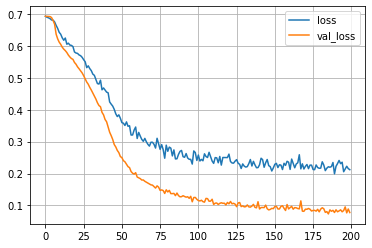

In [35]:
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']
plt.plot(loss1)
plt.plot(val_loss1)
plt.legend(['loss', 'val_loss'])
plt.grid()
plt.show()

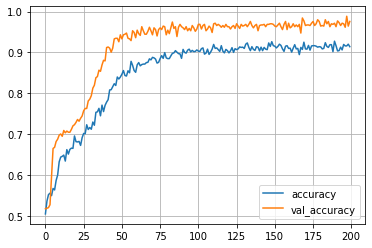

In [36]:
acc1 = history1.history['accuracy']
val_acc1 = history1.history['val_accuracy']
plt.plot(acc1)
plt.plot(val_acc1)
plt.legend(['accuracy', 'val_accuracy'])
plt.grid()
plt.show()

In [37]:
predictions_train = model1.predict(df_train_normalize)
scores=model1.evaluate(df_train_normalize,Y_train,verbose=10)

In [38]:
print('Accuracy on training data: {} \n Error on training data: {}'.format(scores[1], 1 - scores[1]))   

Accuracy on training data: 0.9702000617980957 
 Error on training data: 0.029799938201904297


In [72]:
prediction_test1= model1.predict(df_test_normalize)
scores2 = model1.evaluate(df_test_normalize, Y_test, verbose=4)
print('Accuracy on test data: {} \n Error on test data: {}'.format(scores2[1], 1 - scores2[1])) 

Accuracy on test data: 0.9612711071968079 
 Error on test data: 0.03872889280319214


In [73]:
print("Precision score micro: ",precision_score(prediction_test1.argmax(axis=-1),Y_test.argmax(axis=-1),average="micro")) 

Precision score micro:  0.9612711022840119


In [74]:
print("Precision score macro: ",precision_score(prediction_test1.argmax(axis=-1),Y_test.argmax(axis=-1),average="macro")) # Print macro precision for final class value

Precision score macro:  0.9615363360044211


In [75]:
print("f1_score macro: ",f1_score(prediction_test1.argmax(axis=-1),Y_test.argmax(axis=-1),average="micro")) # Print macro precision for final class value

f1_score macro:  0.9612711022840119


In [80]:
print(classification_report(prediction_test1.argmax(axis=-1),Y_test.argmax(axis=-1)))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       501
           1       0.95      0.97      0.96       506

    accuracy                           0.96      1007
   macro avg       0.96      0.96      0.96      1007
weighted avg       0.96      0.96      0.96      1007



In [76]:
test_followee_id=list(df_test.index)
Y_Predict=[]
for i in tqdm(range(len(test_followee_id))):
    if prediction_test1[i][0]>prediction_test1[i][1]:
        Y_Predict.append(1)
        df_predicted_label.loc[test_followee_id[i]]['Label']='Influencer'
    else:
        df_predicted_label.loc[test_followee_id[i]]['Label']='Not Influencer'
        Y_Predict.append(0)
print(df_predicted_label)

100%|████████████████████████████████████████████████████████████████████████████| 1007/1007 [00:00<00:00, 6456.21it/s]

                              Label
221686362            Not Influencer
784084761463566336       Influencer
844122218183512065       Influencer
1199301128111833088  Not Influencer
3104979654               Influencer
...                             ...
787815967409655812       Influencer
837007740740517893       Influencer
2242478546           Not Influencer
4673407218               Influencer
1722800118               Influencer

[1007 rows x 1 columns]


### Apply Sequential neural network

In [57]:
model2 = tf.keras.Sequential()
model2.add(layers.Dense(500, input_dim=len(df_train_normalize[0]), activation='relu',kernel_initializer='random_normal')) ### Add input layer
model2.add(layers.Dense(100, activation='relu',kernel_initializer='random_normal'))  ### Add one hidden layer
model2.add(layers.Dense(2, activation='sigmoid',kernel_initializer='random_normal'))   ### Add output layer
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [58]:
# fit the model on training data
history2=model2.fit(df_train_normalize, Y_train,epochs=20,batch_size=32,validation_split=0.3, shuffle=False)

Train on 1644 samples, validate on 705 samples
Epoch 1/20
1644/1644 [==============================] - 1s 442us/sample - loss: 0.6688 - acc: 0.5839 - val_loss: 0.6150 - val_acc: 0.6922
Epoch 2/20
1644/1644 [==============================] - 0s 139us/sample - loss: 0.5775 - acc: 0.6971 - val_loss: 0.5063 - val_acc: 0.7688
Epoch 3/20
1644/1644 [==============================] - 0s 112us/sample - loss: 0.4777 - acc: 0.7518 - val_loss: 0.3858 - val_acc: 0.8567
Epoch 4/20
1644/1644 [==============================] - 0s 114us/sample - loss: 0.3381 - acc: 0.8637 - val_loss: 0.2665 - val_acc: 0.9390
Epoch 5/20
1644/1644 [==============================] - 0s 131us/sample - loss: 0.2441 - acc: 0.9167 - val_loss: 0.1945 - val_acc: 0.9532
Epoch 6/20
1644/1644 [==============================] - 0s 105us/sample - loss: 0.1908 - acc: 0.9404 - val_loss: 0.1595 - val_acc: 0.9660
Epoch 7/20
1644/1644 [==============================] - 0s 114us/sample - loss: 0.1616 - acc: 0.9465 - val_loss: 0.1392 - val

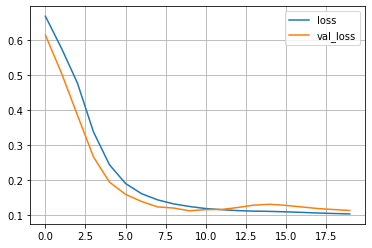

In [59]:
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
plt.plot(loss2)
plt.plot(val_loss2)
plt.legend(['loss', 'val_loss'])
plt.grid()
plt.show()

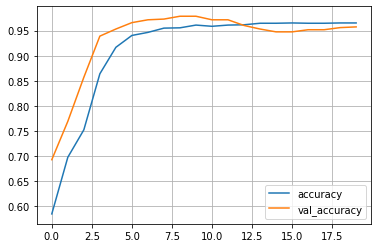

In [60]:
acc2 = history2.history['acc']
val_acc2 = history2.history['val_acc']
plt.plot(acc2)
plt.plot(val_acc2)
plt.legend(['accuracy', 'val_accuracy'])
plt.grid()
plt.show()

In [61]:
# prediction and evaluation on training set
predictions_train = model2.predict(df_train_normalize)
scores=model2.evaluate(df_train_normalize,Y_train,verbose=0)

In [62]:
print('Accuracy on training data: {} \n Error on training data: {}'.format(scores[1], 1 - scores[1]))   

Accuracy on training data: 0.9476373195648193 
 Error on training data: 0.052362680435180664


In [64]:
# prediction and evaluation on testing set
prediction_test2= model2.predict(df_test_normalize)
scores2 = model2.evaluate(df_test_normalize, Y_test, verbose=0)
print('Accuracy on test data: {} \n Error on test data: {}'.format(scores2[1], 1 - scores2[1])) 

Accuracy on test data: 0.9404170513153076 
 Error on test data: 0.05958294868469238


In [65]:
print("Precision score macro: ",precision_score(prediction_test2.argmax(axis=-1),Y_test.argmax(axis=-1),average="macro")) # Print macro precision for final class value
print("Precision score micro: ",precision_score(prediction_test2.argmax(axis=-1),Y_test.argmax(axis=-1),average="micro")) 

Precision score macro:  0.939095251253306
Precision score micro:  0.9404170804369414


In [70]:
print("f1_score macro: ",f1_score(prediction_test2.argmax(axis=-1),Y_test.argmax(axis=-1),average="micro")) # Print macro precision for final class value

f1_score macro:  0.9404170804369414


In [66]:
test_followee_id=list(df_test.index)
df_predicted_label=pd.DataFrame(columns=['Label'],index=test_followee_id)
for i in tqdm(range(len(test_followee_id))):
    if prediction_test[i][0]>prediction_test[i][1]:
        df_predicted_label.loc[test_followee_id[i]]['Label']='Influencer'
    else:
        df_predicted_label.loc[test_followee_id[i]]['Label']='Not Influencer'
print(df_predicted_label)

100%|████████████████████████████████████████████████████████████████████████████| 1007/1007 [00:00<00:00, 6456.59it/s]

                              Label
221686362            Not Influencer
784084761463566336       Influencer
844122218183512065       Influencer
1199301128111833088  Not Influencer
3104979654               Influencer
...                             ...
787815967409655812       Influencer
837007740740517893       Influencer
2242478546           Not Influencer
4673407218               Influencer
1722800118           Not Influencer

[1007 rows x 1 columns]


## Random Forest Model

In [84]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV 
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.ensemble import RandomForestClassifier

In [104]:
model3 = RandomForestClassifier(n_estimators=1,max_depth=8, random_state=80)
model3.fit(df_train, label_train)
prediction_test=model3.predict(df_test)

In [105]:
f1Score_micro=f1_score(list(label_test['Label']),prediction_test,average='micro')
f1Score_macro=f1_score(list(label_test['Label']),prediction_test,average='macro')
acc_score=accuracy_score(label_test['Label'],prediction_test)
print(f"Average micro f1_score is :{f1Score_micro}\n")
print(f"Average macro f1_score is :{f1Score_macro}\n")
print(f"Accuracy VALUE is :{acc_score}\n")    

Average micro f1_score is :0.9811320754716981

Average macro f1_score is :0.9811174766719466

Accuracy VALUE is :0.9811320754716981



In [107]:
precision_recall_fscore_support(list(label_test['Label']),prediction_test,average='macro')

(0.9811450363597602, 0.9810918564717956, 0.9811174766719466, None)

In [43]:
test_followee_id=list(df_test.index)
df_predicted_label=pd.DataFrame(columns=['Label'],index=test_followee_id)
for i in tqdm(range(len(test_followee_id))):
    if prediction_test[i]==1:
        df_predicted_label.loc[test_followee_id[i]]['Label']='Influencer'
    else:
        df_predicted_label.loc[test_followee_id[i]]['Label']='Not Influencer'
print(df_predicted_label)

100%|████████████████████████████████████████████████████████████████████████████| 1007/1007 [00:00<00:00, 3871.79it/s]

                             Label
903449515499241473  Not Influencer
397566887               Influencer
100151711           Not Influencer
3303117168          Not Influencer
1322049606          Not Influencer
...                            ...
2638009812          Not Influencer
919170035343486976      Influencer
2946067253              Influencer
85246452                Influencer
1088949722              Influencer

[1007 rows x 1 columns]
